# GARCH

This notebook contains the results of voltality forecasting with GARCH and a few of it's variants on S&P500 returns.
1. GARCH(1,1) <-- would be nice to also have a method of moments implementation
2. EGARCH(1,1)
3. GJR-GARCH(1,1,1)

In [43]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

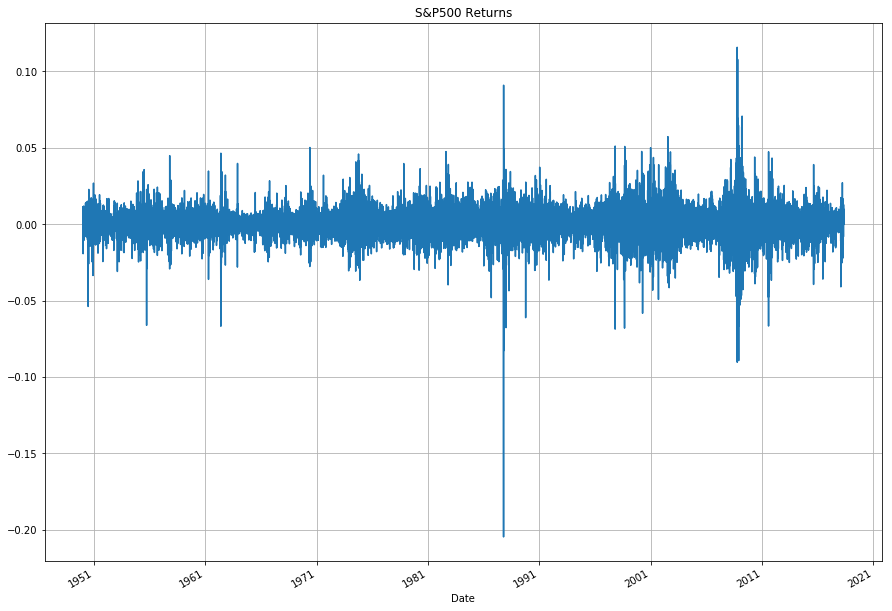

In [44]:
# Read in and adjust data
sp500returns = pd.read_csv("sp500returns.csv", index_col=0, names=['Date', 'Return'])
sp500returns = sp500returns['Return']
sp500returns.index = sp500returns.index.astype('datetime64[ns]')
sp500returns.plot(title='S&P500 Returns',grid=True, figsize=(15, 11));

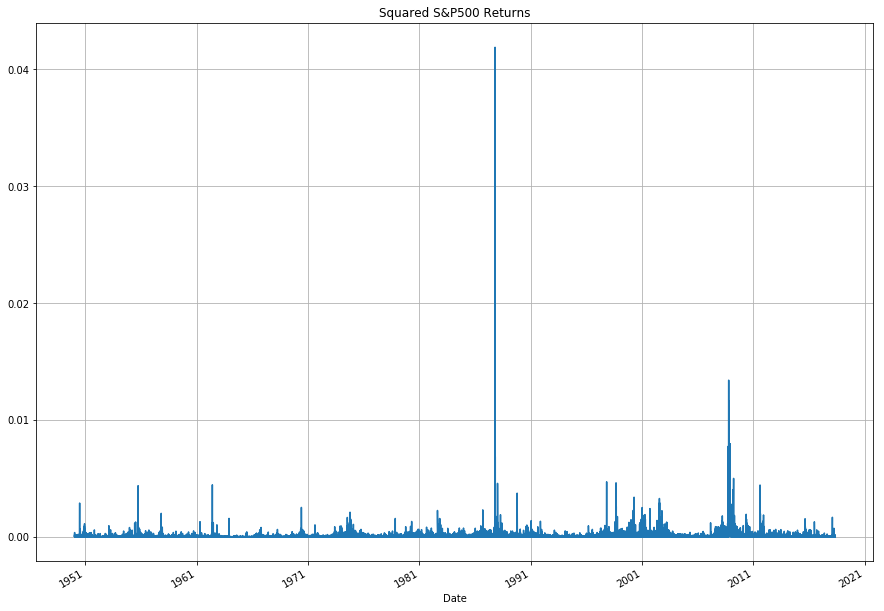

In [45]:
squaredreturns = sp500returns**2
squaredreturns.plot(title = "Squared S&P500 Returns", grid=True, figsize=(15,11))

In [46]:
squaredreturns_standardized = (squaredreturns - np.mean(squaredreturns))/(np.std(squaredreturns))

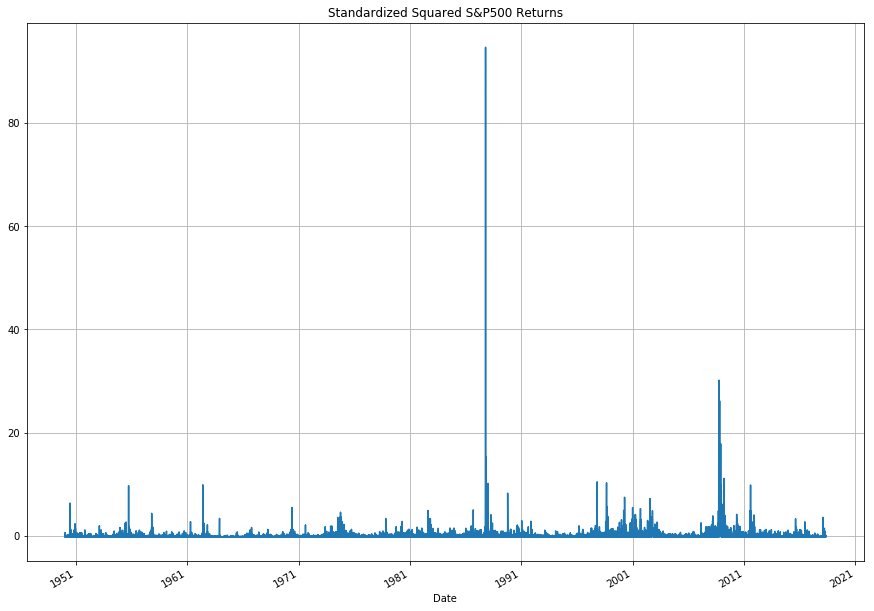

In [47]:
squaredreturns_standardized.plot(title = "Standardized Squared S&P500 Returns", grid=True, figsize=(15,11))

## One-step ahead forecast with GARCH(1,1)

In [56]:
sp500returns[:'1987-10-16']

Date
1950-01-04    0.011405
1950-01-05    0.004748
1950-01-06    0.002953
1950-01-09    0.005889
1950-01-10   -0.002927
1950-01-11    0.003523
1950-01-12   -0.019310
1950-01-13   -0.005370
1950-01-16    0.002999
1950-01-17    0.008373
1950-01-18   -0.000593
1950-01-19    0.001187
1950-01-20    0.001778
1950-01-23    0.001183
1950-01-24   -0.003546
1950-01-25   -0.007117
1950-01-26   -0.000597
1950-01-27    0.005380
1950-01-30    0.011891
1950-01-31    0.001763
1950-02-01    0.000000
1950-02-02    0.010557
1950-02-03    0.003482
1950-02-06    0.001735
1950-02-07   -0.005196
1950-02-08   -0.001161
1950-02-09    0.004068
1950-02-10   -0.002315
1950-02-14   -0.010441
1950-02-15    0.000000
                ...   
1987-09-04   -0.010961
1987-09-08   -0.009915
1987-09-09    0.001148
1987-09-10    0.010226
1987-09-11    0.015293
1987-09-14    0.003416
1987-09-15   -0.016528
1987-09-16   -0.009064
1987-09-17    0.000222
1987-09-18   -0.000222
1987-09-21   -0.013720
1987-09-22    0.028853
1987-0

In [58]:
garch = arch_model (sp500returns[:'1987-10-16'], vol='Garch', p=1, o=0, q=1, dist='Normal')
res = garch.fit(update_freq=10)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -33443.856069493886
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 3


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [59]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                33443.9
Distribution:                  Normal   AIC:                          -66879.7
Method:            Maximum Likelihood   BIC:                          -66851.1
                                        No. Observations:                 9496
Date:                Tue, May 22 2018   Df Residuals:                     9492
Time:                        21:42:38   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.9403e-04  6.234e-05      7.925  2.281e-15 [3.